# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

In [7]:
cv_store = Path(f'parameter_tuning.h5')

### Collect CV predictions

In [11]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

In [27]:
predictions, daily_ic = [], []
with pd.HDFStore(cv_store) as store:
    keys = [k[1:] for k in store.keys() if k.startswith(f'/predictions/{lookahead}')]
    for key in keys:
        train_length, test_length = key.split('/')[2:]
        print(train_length, test_length)
        k = f'{lookahead}/{train_length}/{test_length}'
        cols = {'t': lookahead,
                'train_length': int(train_length),
                'test_length': int(test_length)}
        
        df = store['daily_ic/' + k].assign(**cols).reset_index()
        daily_ic.append(pd.melt(df,
                                id_vars=id_vars,
                                value_name='ic',
                                var_name='rounds')
                        .set_index('date')
                        .apply(pd.to_numeric)
                        .reset_index())
        predictions.append(store['predictions/' + k].assign(**cols))
predictions = pd.concat(predictions)
daily_ic = pd.concat(daily_ic, ignore_index=True)

252 5
756 5
63 21
252 21
252 5
126 21


### Selecting the top 10 parameters

In [15]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

In [32]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29777004 entries, ('1332.JP', Timestamp('2019-12-23 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 28 columns):
 #   Column            Dtype  
---  ------            -----  
 0   y_test            float64
 1   25                float64
 2   50                float64
 3   75                float64
 4   100               float64
 5   125               float64
 6   150               float64
 7   175               float64
 8   200               float64
 9   225               float64
 10  250               float64
 11  275               float64
 12  300               float64
 13  325               float64
 14  350               float64
 15  375               float64
 16  400               float64
 17  425               float64
 18  450               float64
 19  475               float64
 20  500               float64
 21  i                 int64  
 22  bagging_fraction  float64
 23  feature_fraction  float6

In [31]:
def get_params(data, t=5, best=0):
    df = data.sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    print(df.head())
    rounds = str(int(df.rounds))
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [33]:
def get_predictions(preds, params, rounds, t=5):
    return preds.loc[
        (preds.train_length == params.train_length) &
        (preds.test_length == params.test_length) &
        (preds.bagging_fraction == params.bagging_fraction) &
        (preds.feature_fraction == params.feature_fraction) &
        (preds.min_data_in_leaf == params.min_data_in_leaf), rounds]

In [34]:
top_n = 10

### Collecting the corresponding predictions

In [ ]:
for best in range(top_n):
    best_params, rounds = get_params(daily_ic, t=lookahead, best=best)
    if best == 0:
        best_predictions = get_predictions(predictions,
                                           best_params,
                                           rounds,
                                           t=lookahead).to_frame(best)
    else:
        best_predictions[best] = get_predictions(predictions,
                                                 best_params,
                                                 rounds,
                                                 t=lookahead)

In [ ]:
best_predictions.to_hdf('predictions.h5', f'train/{lookahead:02}')
best_predictions.info()

### Get AlphaLens Input

In [16]:
DATA_DIR = Path('..', 'data')

In [17]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'stooq/jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

Using next available prices.

In [18]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 to 2019-12-27
Columns: 215 entries, 1605.JP to 9984.JP
dtypes: float64(215)
memory usage: 2.4 MB


In [47]:
factor = best_predictions.iloc[:, :3].mean(1).tz_localize('UTC', level='date').swaplevel().dropna()

In [48]:
factor.head()

date                       ticker 
2017-12-01 00:00:00+00:00  1605.JP    0.001617
2017-12-04 00:00:00+00:00  1605.JP    0.000378
2017-12-05 00:00:00+00:00  1605.JP    0.000367
2017-12-06 00:00:00+00:00  1605.JP    0.000419
2017-12-07 00:00:00+00:00  1605.JP    0.000610
dtype: float64

In [49]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 108145 entries, (2015-12-14 00:00:00+00:00, 1605.JP) to (2017-12-29 00:00:00+00:00, 9984.JP)
Data columns (total 6 columns):
1D                 108145 non-null float64
5D                 108145 non-null float64
10D                108145 non-null float64
21D                108145 non-null float64
factor             108145 non-null float64
factor_quantile    108145 non-null int64
dtypes: float64(5), int64(1)
memory usage: 5.4+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.021976,0.012777,-0.001078,0.003679,21655,20.024042
2,-0.021413,0.013747,-0.000575,0.003590,21621,19.992603
3,-0.021226,0.014328,-0.000263,0.003580,21618,19.989828
4,-0.020570,0.018960,0.000077,0.003592,21629,20.000000
5,-0.019780,0.019791,0.000988,0.003870,21622,19.993527


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.081,0.033,0.033,0.029
beta,0.083,0.110,0.086,0.053
Mean Period Wise Return Top Quantile (bps),2.705,1.621,2.070,1.859
Mean Period Wise Return Bottom Quantile (bps),-2.456,-2.010,-1.221,-0.873
Mean Period Wise Spread (bps),5.161,3.630,3.294,2.740


<Figure size 432x288 with 0 Axes>

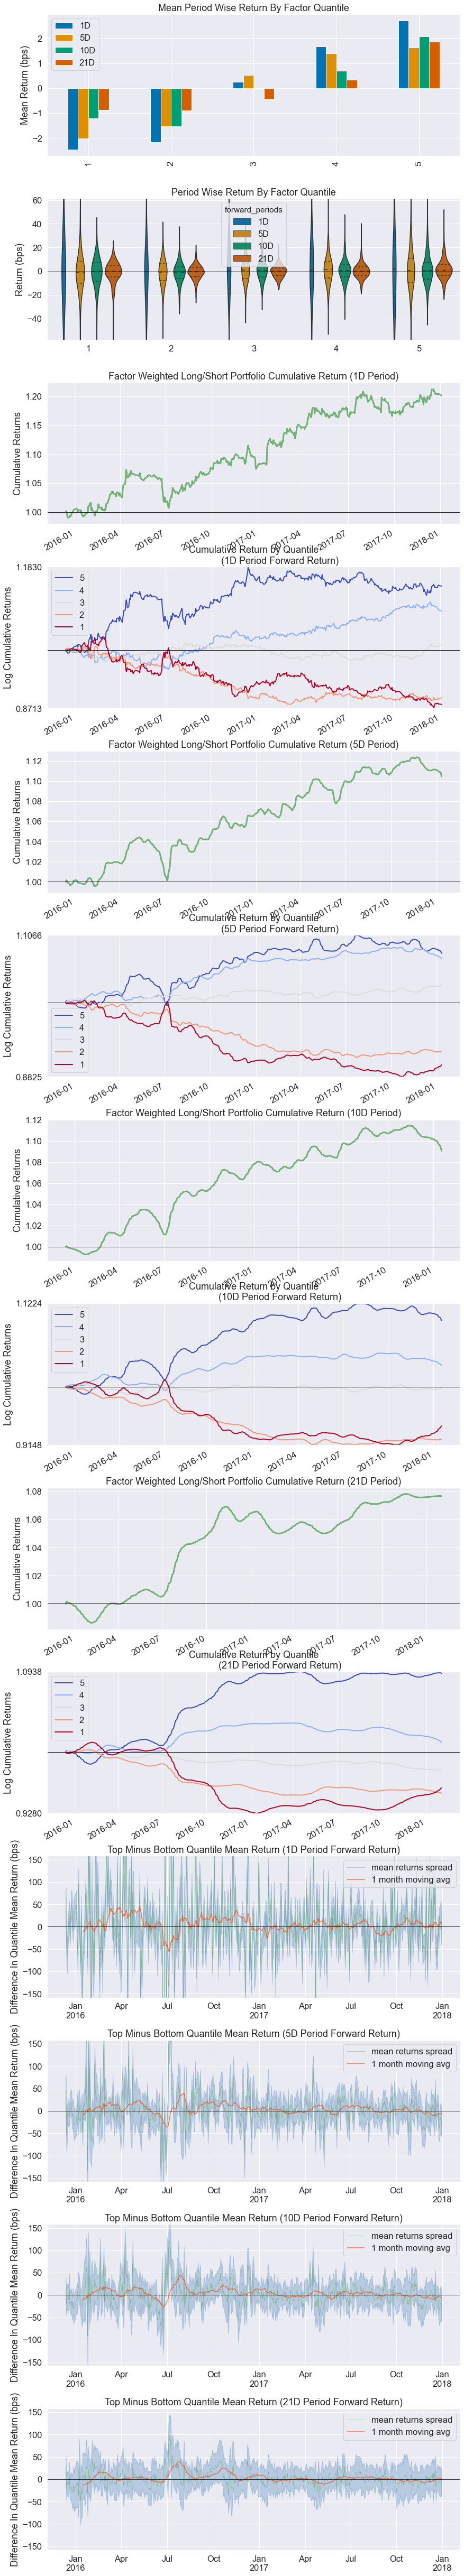

Information Analysis


,1D,5D,10D,21D
IC Mean,0.009,0.015,0.019,0.021
IC Std.,0.156,0.162,0.170,0.157
Risk-Adjusted IC,0.058,0.094,0.111,0.136
t-stat(IC),1.294,2.097,2.498,3.060
p-value(IC),0.196,0.036,0.013,0.002
IC Skew,0.102,0.433,0.511,0.513
IC Kurtosis,0.647,1.048,0.880,0.527


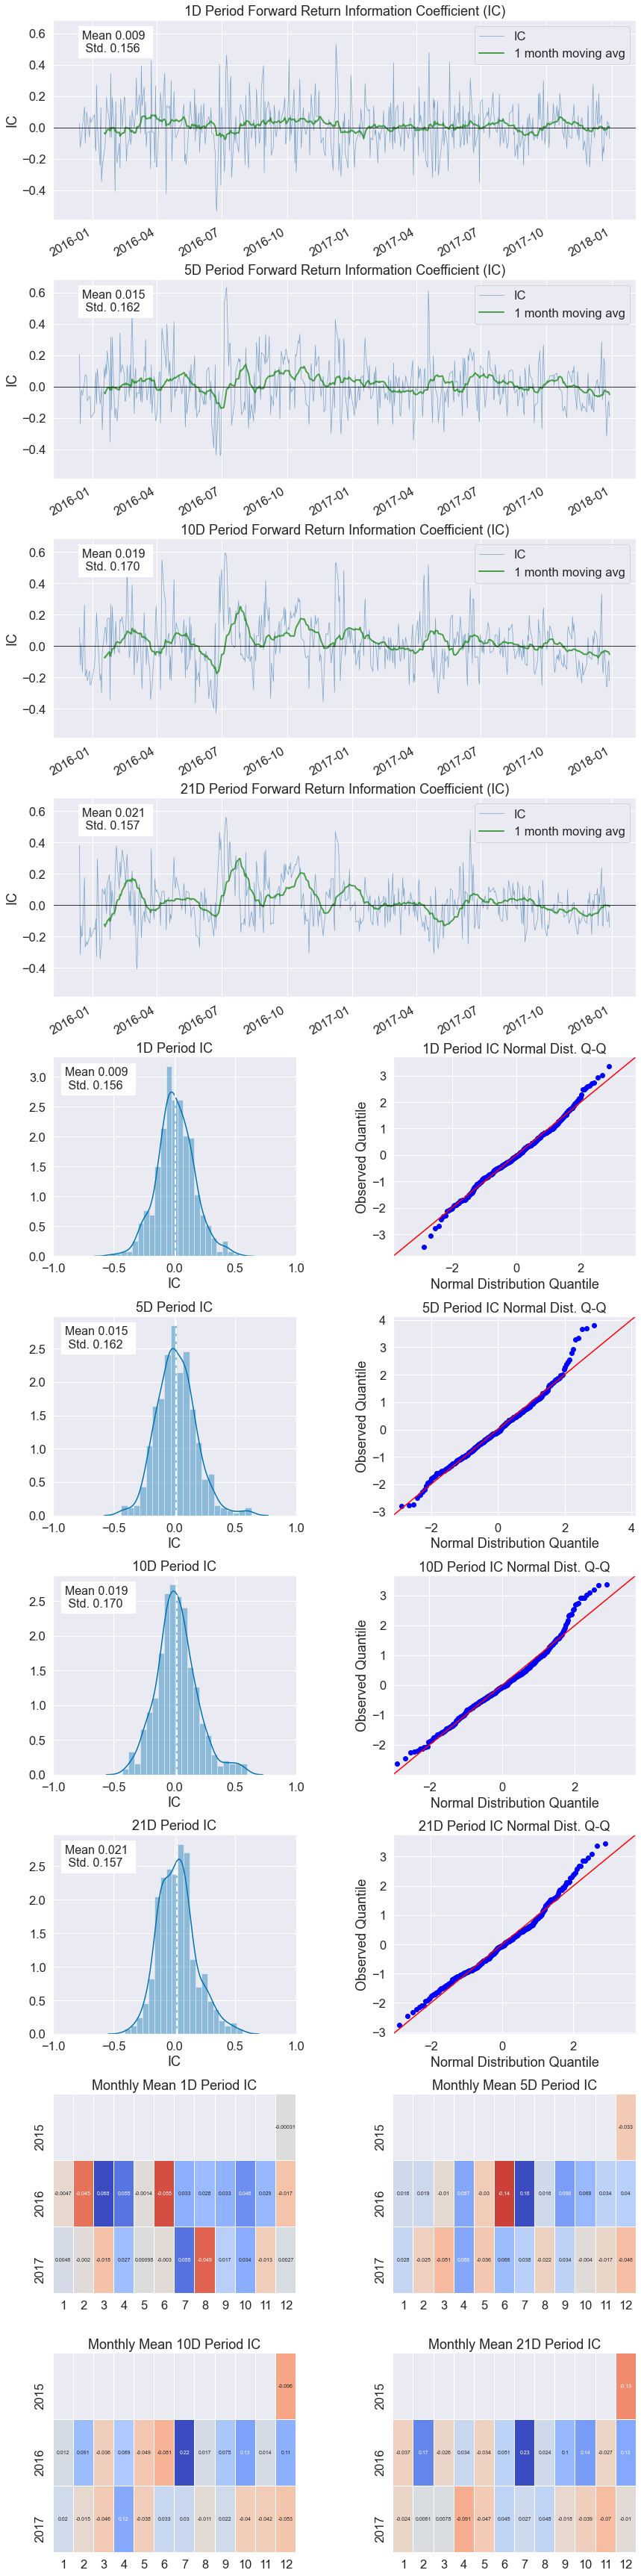

Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.754,0.621,0.796,0.699
Quantile 2 Mean Turnover,0.786,0.704,0.790,0.759
Quantile 3 Mean Turnover,0.789,0.716,0.791,0.769
Quantile 4 Mean Turnover,0.793,0.702,0.799,0.764
Quantile 5 Mean Turnover,0.715,0.552,0.766,0.640


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.352,0.226,0.111,0.017


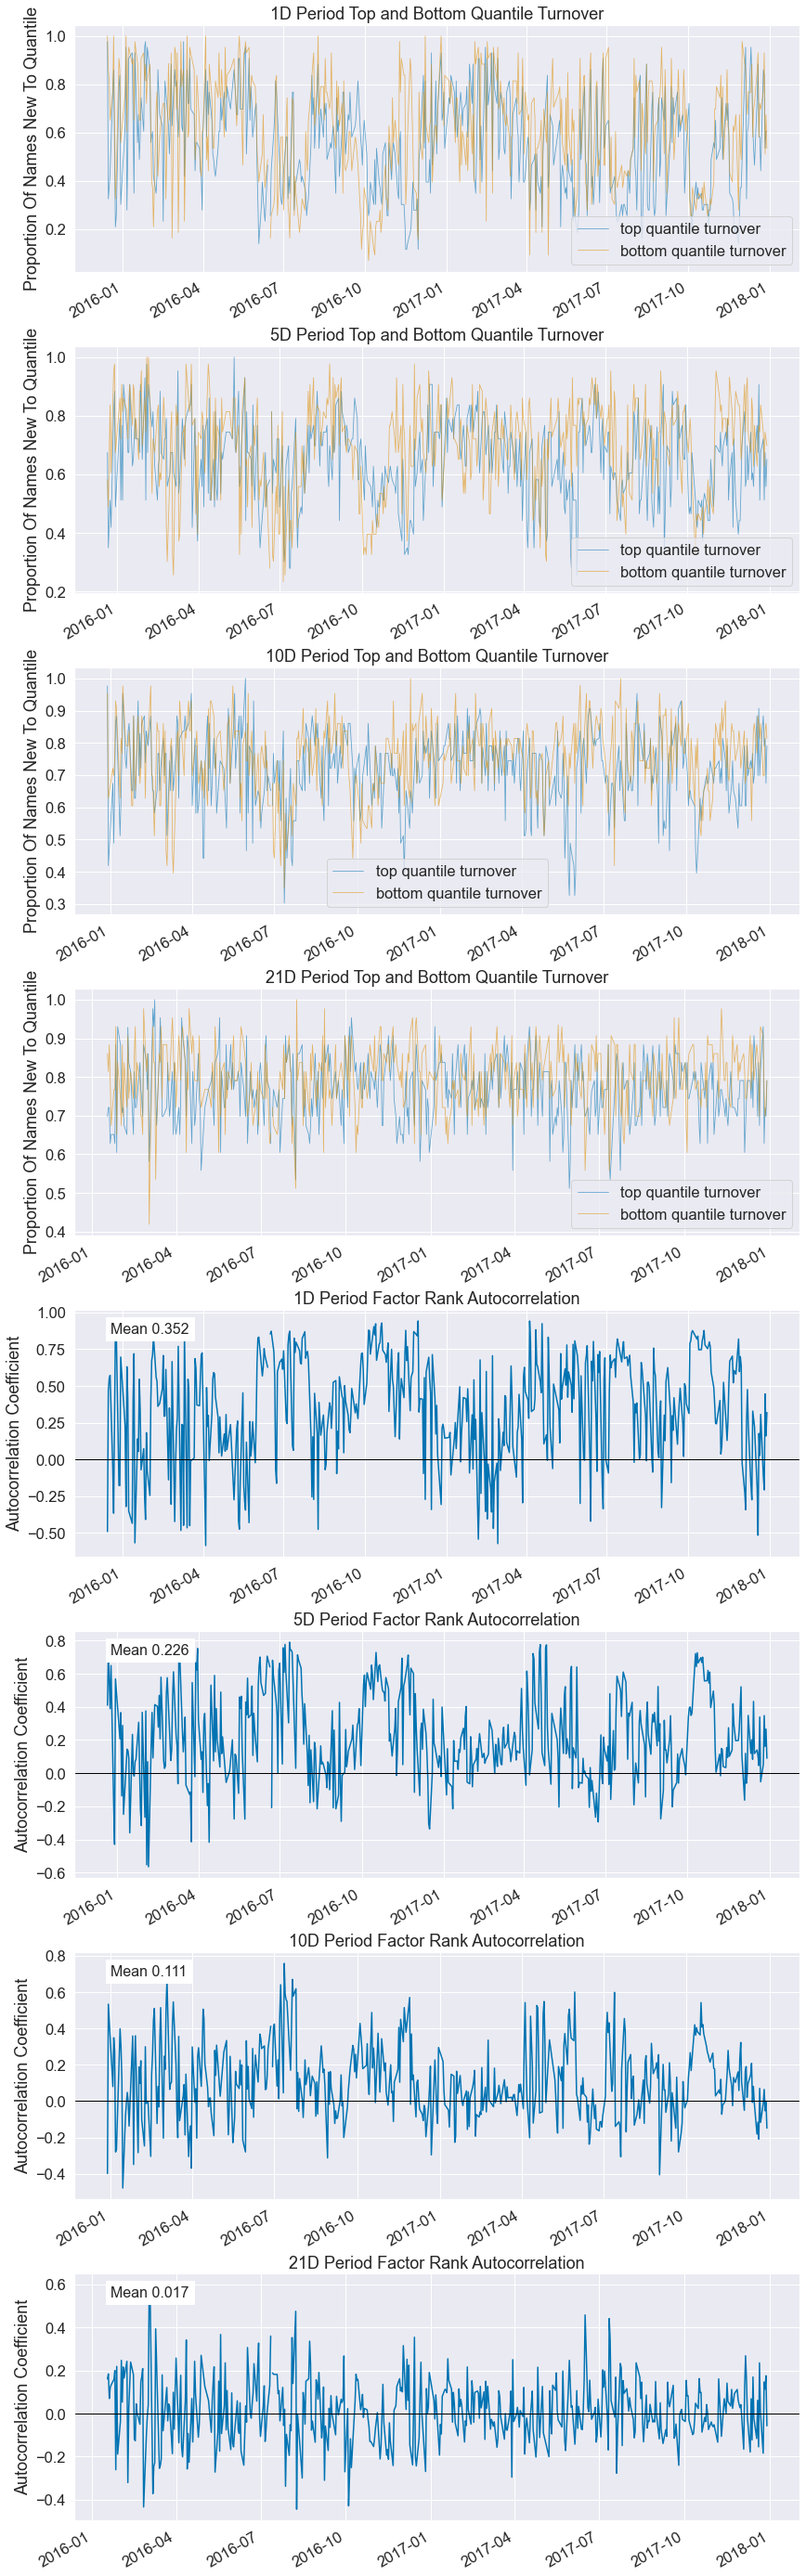

In [51]:
create_full_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [37]:
t = 1
predictions = pd.read_hdf('predictions.h5', f'test/{t:02}').drop('y_test', axis=1)

In [38]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2019-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       474264 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       474264 non-null  float64
 6   6       474264 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       474264 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB


In [69]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2017-12-05 00:00:00+00:00  1332.JP    0.000989
2017-12-06 00:00:00+00:00  1332.JP    0.000992
2017-12-07 00:00:00+00:00  1332.JP    0.000734
2017-12-08 00:00:00+00:00  1332.JP    0.000786
2017-12-11 00:00:00+00:00  1332.JP    0.000920
dtype: float64

### Select next available trade prices

Using next available prices.

In [ ]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

### Get AlphaLens Inputs

In [70]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (2017-12-05 00:00:00+00:00, 1332.JP) to (2019-11-28 00:00:00+00:00, 9990.JP)
Data columns (total 6 columns):
1D                 454503 non-null float64
5D                 454503 non-null float64
10D                454503 non-null float64
21D                454503 non-null float64
factor             454503 non-null float64
factor_quantile    454503 non-null int64
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.030424,0.009378,-0.000102,0.003359,92075,20.258392
2,-0.025986,0.009415,0.000114,0.003162,90773,19.971925
3,-0.025570,0.009491,0.000272,0.003081,90740,19.964665
4,-0.025218,0.015382,0.000482,0.003119,90499,19.911640
5,-0.024394,0.025811,0.001230,0.003472,90416,19.893378


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.010,0.031,0.039,0.027
beta,0.115,0.091,0.073,0.060
Mean Period Wise Return Top Quantile (bps),1.821,1.686,1.865,1.475
Mean Period Wise Return Bottom Quantile (bps),-0.675,-1.560,-1.615,-1.084
Mean Period Wise Spread (bps),2.496,3.232,3.466,2.544


Information Analysis


,1D,5D,10D,21D
IC Mean,0.006,0.015,0.022,0.019
IC Std.,0.121,0.125,0.122,0.122
Risk-Adjusted IC,0.046,0.117,0.183,0.153
t-stat(IC),1.016,2.564,4.030,3.368
p-value(IC),0.310,0.011,0.000,0.001
IC Skew,-0.004,0.248,0.458,0.773
IC Kurtosis,1.167,0.430,0.239,0.681


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.755,0.634,0.793,0.703
Quantile 2 Mean Turnover,0.775,0.721,0.789,0.754
Quantile 3 Mean Turnover,0.784,0.740,0.792,0.771
Quantile 4 Mean Turnover,0.788,0.725,0.800,0.765
Quantile 5 Mean Turnover,0.686,0.535,0.751,0.619


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.363,0.254,0.142,0.037


<Figure size 432x288 with 0 Axes>

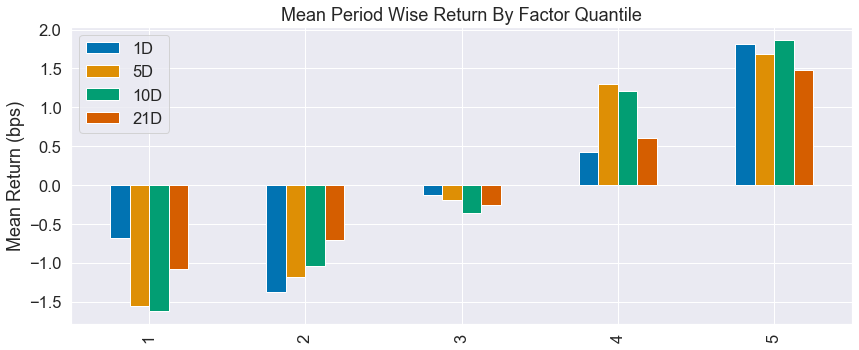

In [71]:
create_summary_tear_sheet(factor_data)

### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)